In [33]:
import numpy as np
import casadi as ca
import chaospy
import scipy
import matplotlib.pyplot as plt

In [2]:
normal = chaospy.Normal(mu=0, sigma=1)

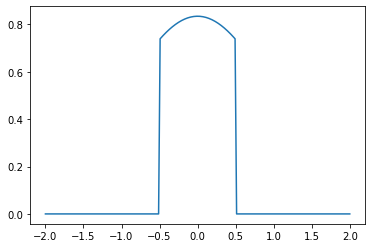

In [3]:
normal_trunc2 = chaospy.Trunc(normal, lower=-0.5, upper=0.5)
q_loc = np.linspace(-2, 2, 200)
pyplot.plot(q_loc, normal_trunc2.pdf(q_loc))
pyplot.show()

In [4]:
normal = chaospy.Normal(mu=0, sigma=0.43)
dis1 = chaospy.Trunc(normal, lower=-0.5, upper=0.5)
dis2 = chaospy.Trunc(normal, lower=-0.5, upper=0.5)

joint = chaospy.J(dis1, dis2)

In [5]:
dis1.sample(2).reshape(-1,1)

array([[-0.17583247],
       [ 0.32460843]])

In [6]:
1/12**2

0.006944444444444444

In [7]:
cov_w = chaospy.Cov(joint)

In [8]:
# joint.sample(size=1,rule = 'random')

In [9]:
def dlqr(A,B,Q,R):
    """
    Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    # first, solve the ricatti equation
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
    # compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*P*B+R)*(B.T*P*A))
    return -K

In [10]:
# K

In [11]:
N_pred = 6
nu = 1
nx = 2

A = np.array([[1.6,1.1],[-0.7,1.2]])
B = np.array([[1],[1]])
D = np.eye(2)
E_ww = 1/12**2 * np.eye(2)
Q = np.eye(2)
R = np.eye(1)

p = 0.8

F = np.array([[1, 0.136]])
G = np.zeros([1, nu])
# E = np.hstack([np.eye(nu), np.zeros(nu, N_pred - 2)])
K = np.array(dlqr(A,B,Q,R))

Phi = A + B @ K

F_tilde = F + G @ K




E_temp1 = np.eye(nu)
E_temp2 = np.zeros([nu, (N_pred-2) * nu])
E = np.hstack([E_temp1,E_temp2])

M_temp1 = np.eye(nu * (N_pred - 2))
M_temp2 = np.vstack([M_temp1, np.zeros([nu, M_temp1.shape[1]])])

M = np.hstack([np.zeros([M_temp2.shape[0],nu]),M_temp2])

F_bar = np.hstack([F_tilde, G@E])
Psi = np.vstack([np.hstack([Phi, B @ E]), np.hstack([np.zeros([np.shape(M)[0],np.shape(Phi)[1]]), M])])

In [12]:
M.shape

(5, 5)

System

In [13]:
A_DM = ca.DM(A)
B_DM = ca.DM(B)
D_DM = ca.DM(D)
E_ww_DM = ca.DM(E_ww)
Q_DM = ca.DM(Q)
R_DM = ca.DM(R)

Phi_DM = ca.DM(Phi)

Offline-calculation

Beta

gamma

In [14]:
N_gamma = 10

gamma_list = []

kappa = np.sqrt(p/(1-p))

g = F.T


P1 = D @ cov_w @ D.T
Pi = P1

for i in range(N_gamma):
    gamma_i = kappa * np.sqrt(g.T @ Pi @ g)
    gamma_list += [gamma_i]
    
    Pi_p1 = Phi @ Pi @ Phi.T + D @ cov_w @ D.T
    Pi = Pi_p1


In [15]:
gamma_list

[array([[0.53152455]]),
 array([[0.55929024]]),
 array([[0.56016487]]),
 array([[0.56027406]]),
 array([[0.56040883]]),
 array([[0.5604517]]),
 array([[0.56045857]]),
 array([[0.56045908]]),
 array([[0.56045908]]),
 array([[0.56045909]])]

In [16]:
solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 300,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}

i_max = 10

w_sym = ca.SX.sym("w",2)
a_list = []

nl = {}

lbx = [-0.5] * 2
ubx = [0.5] * 2

nl['lbx'] = lbx
nl['ubx'] = ubx

for i in range(1,i_max):
    obj = - F_tilde @ np.linalg.matrix_power(Phi, i) @ D @ w_sym

    nlp_prob = {
    'f': obj,
    'x': w_sym
    }

    solver = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)

    sol = solver(**nl)


    a_list += [-sol['f'].full()]


    



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [17]:
a_list

[array([[0.19778557]]),
 array([[0.04023669]]),
 array([[0.01341676]]),
 array([[0.01168454]]),
 array([[0.00716333]]),
 array([[0.00303603]]),
 array([[0.00089288]]),
 array([[9.8153436e-05]]),
 array([[0.00011195]])]

In [18]:
beta_list = []
gamma_1 = gamma_list[0]
beta_temp = gamma_1
for i in range(1,i_max):
    beta_temp = beta_temp + a_list[i-1]
    beta_list += [beta_temp]

In [19]:
beta_list

[array([[0.72931012]]),
 array([[0.7695468]]),
 array([[0.78296356]]),
 array([[0.7946481]]),
 array([[0.80181143]]),
 array([[0.80484746]]),
 array([[0.80574034]]),
 array([[0.80583849]]),
 array([[0.80595044]])]

Objective function

$$
J\left(x_{k}, \mathbf{c}_{k}\right)=\sum_{i=0}^{\infty} \mathbb{E}_{k}\left(\left\|x_{i \mid k}\right\|_{Q}^{2}+\left\|u_{i \mid k}\right\|_{R}^{2}-l_{s s}\right)=x_{k}^{T} W_{x} x_{k}+\mathbf{c}_{k}^{T} W_{c} \mathbf{c}_{k}+w_{1}
$$

$$
W_{x}-\mathbb{E}\left(\left(A_{k}+B_{k} K\right)^{T} W_{x}\left(A_{k}+B_{k} K\right)\right)=Q+K^{T} R K
$$

$$
A^{H} X A-X-\left(A^{H} X B\right)\left(R+B^{H} X B\right)^{-1}\left(B^{H} X A\right)+Q=0
$$

In [20]:
Wx = scipy.linalg.solve_discrete_are(A+B@K, np.zeros([2,2]), Q + K.T @ R @ K, np.diag([0.01,0.01]))

In [21]:
Wx

array([[10.39419575,  0.80911714],
       [ 0.80911714,  2.18978722]])

In [22]:
nc = N_pred - 1

Wc = R + B.T @ Wx @ B
for i in range(nc-1):
    Wc = scipy.linalg.block_diag(Wc, R + B.T @ Wx @ B)



# temp = scipy.linalg.block_diag(Wx,Wx)

In [23]:
Wc

array([[15.20221724,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 15.20221724,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 15.20221724,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 15.20221724,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 15.20221724]])

In [24]:
a = ca.SX.sym("a",2)
b = ca.SX.sym("b",2)
ca.vertcat(a,b)

SX([a_0, a_1, b_0, b_1])

In [25]:
# Not necesssary to solve the Lyapunov eq.

In [26]:
np.shape(F_bar @ np.linalg.matrix_power(Psi, i))

(1, 7)

In [27]:
# ca.vertcat( x0_para, ck_var)

In [28]:
Psi.shape

(7, 7)

In [29]:
x0 = np.array([[-5],[60]])


v = 5 # i_max


# u_ub = [1]
# u_nom_ub = [u_ub-Z_proj_max]

# u_lb = [-1]
# u_nom_lb = [-1-Z_proj_min]

# x_ub = [ca.inf, 2]
# x_lb = [-ca.inf, -ca.inf]

# x_nom_ub = [ca.inf, 2 - Z.V[:,1].max()]
# x_nom_lb = [-ca.inf, -ca.inf]

# xi_var = ca.SX.sym('x', nx, N_pred)
x0_para = ca.SX.sym('x0', nx, 1)
ck_var = ca.SX.sym('ck', N_pred - 1,nu)

obj = 0
g = []
for i in range(v):
    g += [F_bar @ np.linalg.matrix_power(Psi, i) @ ca.vertcat( x0_para, ck_var) ]

# obj += x0_para.T @ Wx @ x0_para + ck_var.T @ Wc @ ck_var
obj += ck_var.T @ Wc @ ck_var
# g += [xi_var[:, -1] - (A_para @ xi_var[:, -2] + B_para @ ui_var[:,  -1])] # Terminal state


dec_list = [ca.reshape(ck_var, -1, 1)]
para_list = [x0_para]

nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 300,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}

solver = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)

In [ ]:
N_sim = 20

nl = {}



lbg = []
ubg = []

one_vec = np.ones([np.shape(F_bar)[0],1])
for i in range(v):
    ubg += [one_vec - beta_list[i]]

lbg = [-ca.inf] * v

nl['lbg'] = lbg
nl['ubg'] = ubg

In [40]:
N_loop = 30

x_diff_traj_list = []
for i in range(N_loop):

    x0 = np.array([[-5],[60]])
    x_traj_list = []
    x_traj_list += [x0]
    xk = x0

    for i in range(N_sim):  
        nl['p'] = xk
        sol = solver(**nl)
        ck = sol['x'][0].full()
        # x0_sol = sol['x'][:nx].full()
        uk = ck + K @ xk
        wk = dis1.sample(2).reshape(-1,1)
        xk_next = A @ xk + B @ uk + D @ wk
        x_traj_list += [xk_next]

        xk = xk_next
        
        
    x_diff_traj_list += [x_traj_list]

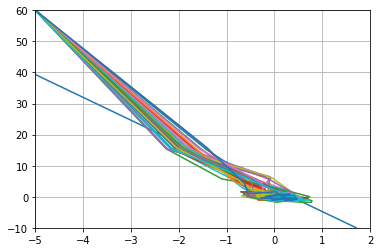

In [41]:
fig1, ax1 = plt.subplots(num=1)

plt.grid()
plt.axis([-5, 2, -10, 60])

# P_VT.plot(ax10, fill=False, edgecolor='r', linewidth=2)

constr_x1 = [-5, 1.71]
constr_x2 = [39.338, -10]


plt.plot(constr_x1, constr_x2)

for i in range(N_loop):
    x_traj_array = np.hstack(x_diff_traj_list[i])
    ax1.plot(x_traj_array[0,:],x_traj_array[1,:])
